In [1]:
from nets import ConvDecoder, Classifier
from fep import FEP
import torch
import pickle
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp2d

In [2]:
def norm_pose(pose):
    x = (pose[0] + 8) / (8 + 8)
    y = (pose[1] + 8) / (8 + 8)

    return [x, y]

def unnorm_pose(pose):
    x = pose[0] * (8 + 8) - 8
    y = pose[1] * (8 + 8) - 8

    return [x, y]

In [3]:
decoder1 = ConvDecoder()
decoder1.cpu()
decoder1.load_state_dict(torch.load("/home/simon/catkin_ws/src/turtlebot3_gazebo/scripts/trained_conv_nets/deconv_shapes_fixed_2_200e_USE.pt"))
decoder1.eval()

decoder2 = ConvDecoder()
decoder2.cpu()
decoder2.load_state_dict(torch.load("/home/simon/catkin_ws/src/turtlebot3_gazebo/scripts/trained_conv_nets/deconv_shapes_dif_fixed_1_200e_USE.pt"))
decoder2.eval()
ls_decoders = [decoder1, decoder2]

classifier = Classifier()
classifier.cpu()
classifier.load_state_dict(torch.load("/home/simon/catkin_ws/src/turtlebot3_gazebo/scripts/trained_conv_nets/context_classifier_3_100e_USE.pt"))
classifier.eval()

Classifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(12, 18, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=648, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

In [8]:
with open("/home/simon/catkin_ws/src/turtlebot3_gazebo/scripts/data/shapes_random_samples_100.pkl", 'rb') as f:
    pose_samples, img_samples = pickle.load(f)

error_histories = np.empty((1, 100))

dist_histories = np.empty((1,2))

start_beliefs = []
end_beliefs = []

lim = 8

for i in range(10):
    for j in range(10):
        fep = FEP(ls_decoders, classifier, active_inference=False, context_aware=True)
        fep.sigma_o = 1*1e3

        sample_idx = random.randint(0, img_samples.shape[0]-1)
        true_state = pose_samples[sample_idx]
        observation = decoder1.forward(torch.tensor(true_state, dtype=torch.float)).squeeze().detach().numpy()

        x = np.round(np.random.uniform(-lim, lim), 3)
        y = np.round(np.random.uniform(-lim, lim), 3)
        start_belief_norm = norm_pose([x, y])
        
        start_belief = [x, y]


        path = fep.run(start_belief_norm, observation, 100)
        final_belief = path[-1]
        final_belief_unnorm = unnorm_pose(final_belief)

        path_unnorm = np.array([unnorm_pose(x) for x in path])
        true_state_unnorm = unnorm_pose(true_state)

        start_beliefs.append(start_belief)
        end_beliefs.append(final_belief_unnorm)

        

        real_dist = np.sqrt((x - true_state_unnorm[0]) ** 2 + (y - true_state_unnorm[1]) ** 2)
        end_error = np.sqrt((final_belief_unnorm[0] - true_state_unnorm[0]) ** 2 + (final_belief_unnorm[1] - true_state_unnorm[1]) ** 2)

        dists = np.array([[real_dist, end_error]])

        dist_histories = np.concatenate((dist_histories, dists), 0)


        # error_per_step = np.array([[np.sqrt((true_state_unnorm[0] - x[0]) ** 2 + (true_state_unnorm[1] - x[1]) ** 2) for x in path_unnorm]])

        # error_histories = np.concatenate((error_histories, error_per_step), 0)

    print(i)

0
1
2
3
4
5
6
7
8
9


In [9]:
start_pose_x = [x[0] for x in start_beliefs]
start_pose_y = [x[1] for x in start_beliefs]

end_pose_x = [x[0] for x in end_beliefs]
end_pose_y = [x[1] for x in end_beliefs]

error_x = []

for i, x in enumerate(start_pose_x):
    error_x.append(abs(x - end_pose_x[i]))


error_y = []

for i, x in enumerate(start_pose_y):
    error_y.append(abs(x - end_pose_y[i]))

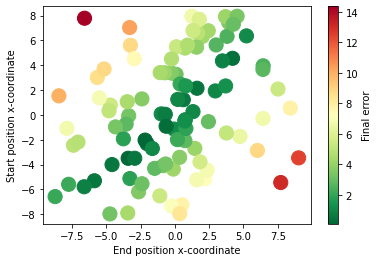

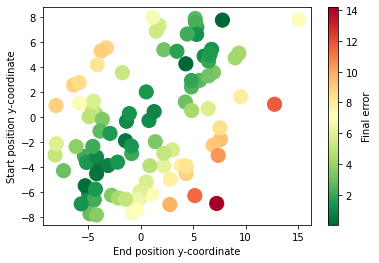

In [10]:
plt.scatter(end_pose_x, start_pose_x, c=error_x, s=200, cmap='RdYlGn_r')
cbar = plt.colorbar()
cbar.set_label('Final error')
plt.xlabel('End position x-coordinate')
plt.ylabel('Start position x-coordinate')
plt.show()

plt.scatter(end_pose_y, start_pose_y, c=error_y, s=200, cmap='RdYlGn_r')
cbar = plt.colorbar()
cbar.set_label('Final error')
plt.xlabel('End position y-coordinate')
plt.ylabel('Start position y-coordinate')
plt.show()

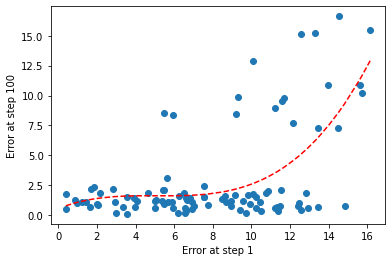

In [19]:
dist_histories = dist_histories[1:]
ls_sorted = sorted(dist_histories, key=lambda x: x[0])
ls_sorted = np.array(ls_sorted)

plt.figure(figsize=(6,4))
plt.xlabel('Error at step 1')
plt.ylabel('Error at step 100')
plt.scatter(ls_sorted[:, 0], ls_sorted[:, 1])

z = np.polyfit(ls_sorted[:, 0], ls_sorted[:, 1], 3)
p = np.poly1d(z)
plt.plot(ls_sorted[:, 0],p(ls_sorted[:, 0]),"r--")
plt.show()

In [305]:
# avg_4 = np.mean(error_histories, 0)
# std_4 = np.std(error_histories, 0)

In [ ]:
# avg_8 = np.mean(error_histories, 0)
# std_8 = np.std(error_histories, 0)

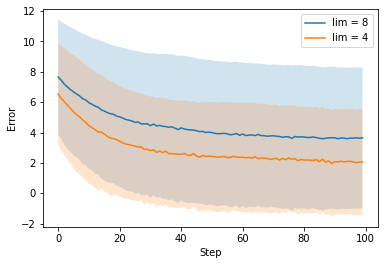

In [345]:
plt.figure(figsize=(6,4))
plt.xlabel('Step')
plt.ylabel('Error')

lower_8 = avg_8 - std_8
upper_8 = avg_8 + std_8

plt.plot(avg_8, label='lim = 8')
plt.fill_between(range(100), lower_8, upper_8, alpha=0.2)
plt.plot(avg_4, label='lim = 4')
plt.fill_between(range(100), lower_4, upper_4, alpha=0.2)


plt.legend()

plt.show()